### File Loads & Text Scraping

In [49]:
#Package imports
from bs4 import BeautifulSoup
import pandas as pd
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from googlesearch import search
import yfinance as yf #this requires a package adjustment to work (yikes)
sns.set_style('darkgrid')

In [50]:
#Pulling files from local repo (automation coming soon)
files = os.listdir('/Users/BrandonToushan/Desktop/13f')

In [51]:
#Function to scrape SEC 13f info table files using BeautifulSoup
def scrape_13f(file):
    html = open("/Users/BrandonToushan/Desktop/13f/"+file).read()
    soup = BeautifulSoup(html, 'lxml')
    rows = soup.find_all('tr')[11:]
    positions = []
    for row in rows:
        dic = {}
        position = row.find_all('td')
        dic["NAME_OF_ISSUER"] = position[0].text
        dic["TITLE_OF_CLASS"] = position[1].text
        dic["CUSIP"] = position[2].text
        dic["VALUE"] = int(position[3].text.replace(',', ''))*1000
        dic["SHARES"] = int(position[4].text.replace(',', ''))
        positions.append(dic)
        
    df = pd.DataFrame(positions)
    return df

### Renaissance Top 50 Holdings by Value [Q3 2020]

In [52]:
#Scraping 13f and displaying resulting df
file_name = "RENAISSANCE_Q3_2020.htm"
renaissance_df = scrape_13f(file_name)
renaissance_df.head()

,NAME_OF_ISSUER,TITLE_OF_CLASS,CUSIP,VALUE,SHARES
0,10X GENOMICS INC,CL A COM,88025U109,25867000,289636
1,111 INC,ADS,68247Q102,894000,140847
2,1347 PPTY INS HLDGS INC,COM,68244P107,428000,95962
3,1LIFE HEALTHCARE INC,COM,68269G107,15349000,422600
4,1ST CONSTITUTION BANCORP,COM,31986N102,1693000,136494


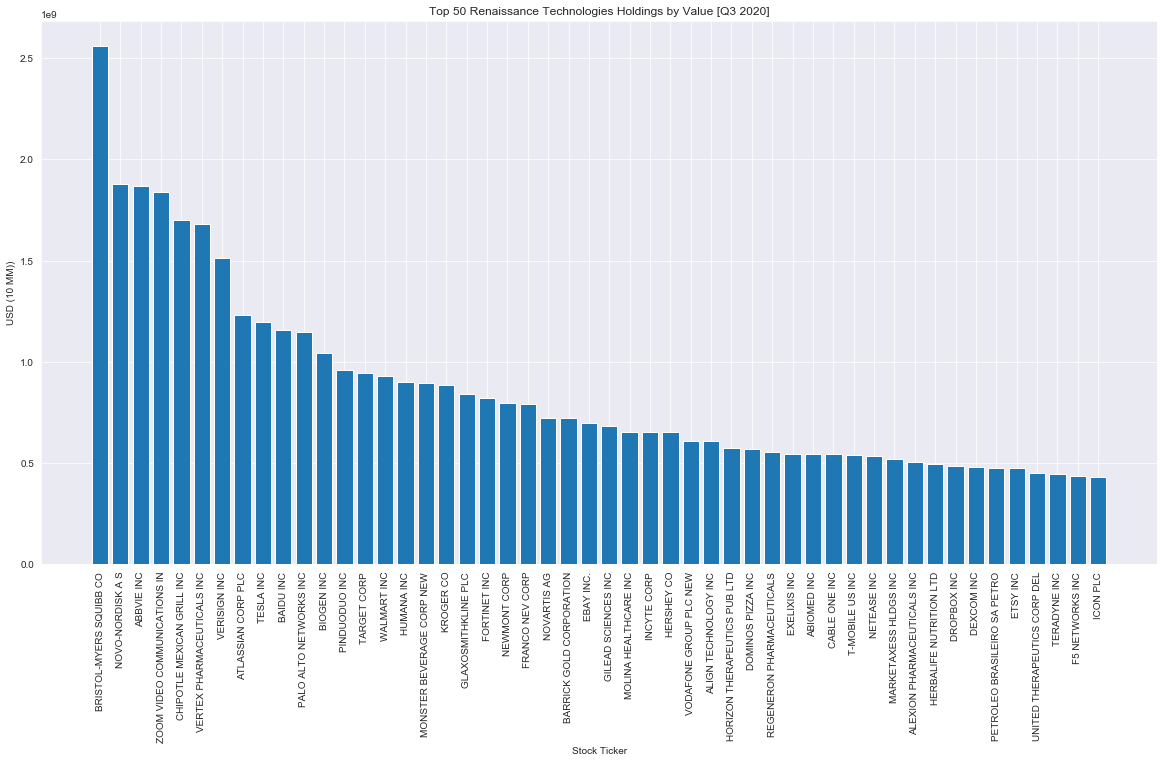

In [60]:
#Extracting top 50 holdings by value
top_50_renaissance = renaissance_df.sort_values(by="VALUE", ascending=False)[["NAME_OF_ISSUER","VALUE"]][:50]
a = top_50_renaissance.NAME_OF_ISSUER
b = top_50_renaissance.VALUE
c = range(len(b))

#Visualizing top 50 holdings
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(c, b)

plt.xticks(c, a, rotation=90);
plt.title('Top 50 Renaissance Technologies Holdings by Value [Q3 2020]');
plt.xlabel('Stock Ticker');
plt.ylabel('USD (10 MM))');
plt.show();

### Functions to Extract Tickers & Financials

In [6]:
#Function to convert company names to tickers
def ticker_convert(self):
    searchval = 'yahoo finance '+self
    link = []
    #limits to the first link
    for url in search(searchval, tld='es', lang='es', stop=1):
        link.append(url)
    link = str(link[0])
    link=link.split("/")
    if link[-1]=='':
        ticker=link[-2]
    else:
        x=link[-1].split('=')
        ticker=x[-1]
    return(ticker)

#Function converts arrays of names into arrays of tickers using name_convert
def ticker_array_convert(self):
    ticker_list = []
    for i in self:
        val = ticker_convert(i)
        ticker_list.append(val)
    return(ticker_list)

#Function uses yfinance package to pull forward various important values from yahoo finance
def company_info(self):
    company = yf.Ticker(self)
    info = company.info
    market_cap = info['marketCap']
    ev = info['enterpriseValue']
    ev_to_rev = info['enterpriseToRevenue']
    ev_to_ebitda = info['enterpriseToEbitda']
    forwardPE = info['forwardPE']
    return [market_cap,ev,ev_to_rev,ev_to_ebitda,forwardPE]

#Function pulls company_data func to pull values from yahoo finance for an array of tickers
def company_info_df(self):
    data_array = []
    for i in self:
        val = company_info(i)
        data_array.append(val)
        info_df = pd.DataFrame(np.vstack(data_array),columns = ['MARKET_CAP','ENTERPRISE_VAL','ENTERPRISE_VAL_TO_REV',
                                                                'ENTERPRISE_VAL_TO EBITDA','FORWARD_PE'] )
    return(info_df)

### Analyzing Renaissance's Top 30 Holdings

In [8]:
#Extracting tickers for Two Sigma's top 30 holdings using ticker_array_convert() func
top_30_renaissance_df = renaissance_df.sort_values(by="VALUE", ascending=False)[["NAME_OF_ISSUER","VALUE"]][:30]
top_30_renaissance = list(top_30_renaissance_df.NAME_OF_ISSUER)
top_30_renaissance_tickers = ticker_array_convert(top_30_renaissance)

In [9]:
#Pulling in finanical/economic data for Renaissance's top 30 holdings using company_info_df() func
top_30_renaissance_info = company_info_df(top_30_renaissance_tickers)

In [14]:
#Resetting df indices
top_30_renaissance_info.reset_index(drop=True, inplace=True)
top_30_renaissance_df.reset_index(drop=True, inplace=True)

#Concatenating the two dfs into one and dropping nans
top_30_renaissance_complete_df = pd.concat([top_30_renaissance_df,top_30_renaissance_info],axis=1)
top_30_renaissance_complete_df = top_30_renaissance_complete_df.dropna()
top_30_renaissance_complete_df.head(10)

,NAME_OF_ISSUER,VALUE,MARKET_CAP,ENTERPRISE_VAL,ENTERPRISE_VAL_TO_REV,ENTERPRISE_VAL_TO EBITDA,FORWARD_PE
0,BRISTOL-MYERS SQUIBB CO,2557631000,1.422e+11,1.67848e+11,4.815,11.986,8.52568
2,ABBVIE INC,1867567000,1.696e+11,2.50255e+11,6.908,14.959,7.94872
3,ZOOM VIDEO COMMUNICATIONS IN,1839695000,7.7158e+10,7.70525e+10,92.965,1227.18,174.21
4,CHIPOTLE MEXICAN GRILL INC,1698869000,3.41029e+10,3.66937e+10,6.53,66.144,58.3989
5,VERTEX PHARMACEUTICALS INC,1678378000,7.03443e+10,6.57387e+10,12.168,29.747,23.9424
6,VERISIGN INC,1512070000,2.36772e+10,2.43726e+10,19.563,28.225,35.2393
7,ATLASSIAN CORP PLC,1232148000,4.04552e+10,4.04026e+10,25.03,854.448,106.634
8,TESLA INC,1195248000,3.50087e+11,3.60025e+11,14.004,104.507,120.806
10,PALO ALTO NETWORKS INC,1146111000,2.59956e+10,2.54769e+10,7.806,692.306,46.3821
11,BIOGEN INC,1045029000,4.43245e+10,9.49587e+10,6.555,11.802,8.80717


### Summary Stats

In [56]:
#Forward P/E ratio
print("P/E RATIO")
print("MEAN:",top_30_renaissance_complete_df['FORWARD_PE'].mean())
print("MAX:",top_30_renaissance_complete_df['FORWARD_PE'].max(),)
print("MIN:",top_30_renaissance_complete_df['FORWARD_PE'].min(),'\n')

#Enterprise value-to-rev
print('ENTERPRISE VALUE-TO-REVENUE')
print("MEAN:",top_30_renaissance_complete_df['ENTERPRISE_VAL_TO_REV'].mean())
print("MAX:",top_30_renaissance_complete_df['ENTERPRISE_VAL_TO_REV'].max(),)
print("MIN:",top_30_renaissance_complete_df['ENTERPRISE_VAL_TO_REV'].min())

P/E RATIO
MEAN: 40.407358984000005
MAX: 174.21019
MIN: 7.9487176 

ENTERPRISE VALUE-TO-REVENUE
MEAN: 11.39932
MAX: 92.965
MIN: 0.364


### Visualizing Results

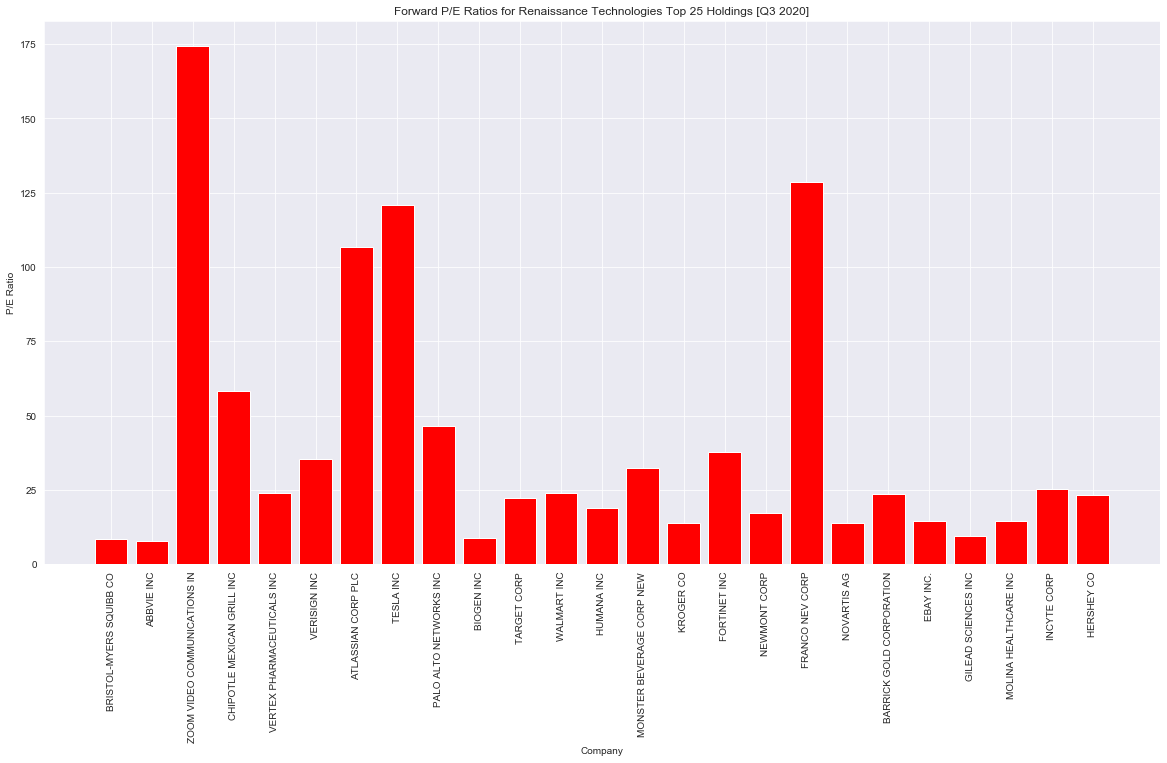

In [57]:
#Forward P/E ratios

#Extracting values from df
a = top_30_renaissance_complete_df.NAME_OF_ISSUER
b = top_30_renaissance_complete_df.FORWARD_PE
c = range(len(b))

#Plotting results
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(c, b,color ='red')
plt.xticks(c, a, rotation=90);
plt.title('Forward P/E Ratios for Renaissance Technologies Top 25 Holdings [Q3 2020]');
plt.xlabel('Company');
plt.ylabel('P/E Ratio');
plt.show();

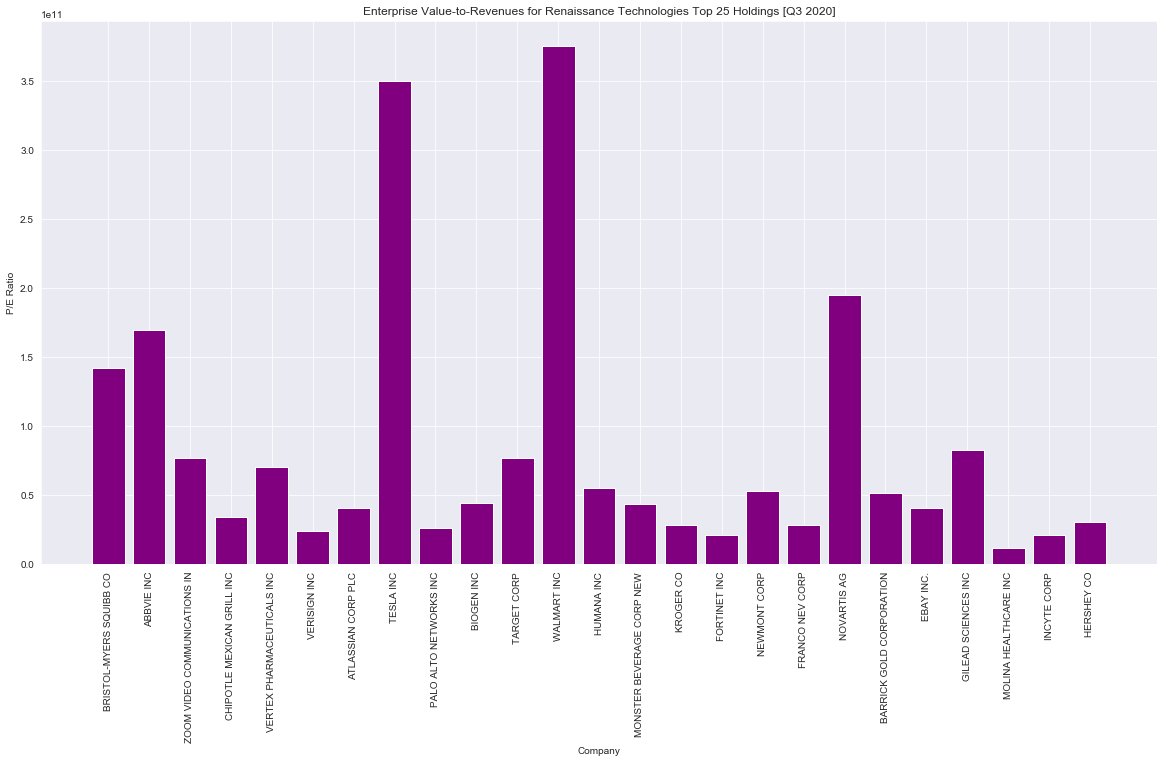

In [58]:
#Market caps

#Extracting values from df
a = top_30_renaissance_complete_df.NAME_OF_ISSUER
b = top_30_renaissance_complete_df.MARKET_CAP
c = range(len(b))

#Plotting results
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(c, b,color ='purple')
plt.xticks(c, a, rotation=90);
plt.title('Enterprise Value-to-Revenues for Renaissance Technologies Top 25 Holdings [Q3 2020]');
plt.xlabel('Company');
plt.ylabel('P/E Ratio');
plt.show();

### Exporting to Excel

In [59]:
#Exporting
top_30_renaissance_complete_df.to_excel("Renaissance_top_25.xlsx",sheet_name='Renaissance')  